In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
cd "/content/drive/My Drive/MachineLearningMy"


/content/drive/My Drive/MachineLearningMy


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)



train_df = pd.read_csv(
    "train.csv", 
    index_col="tripid"
)
test_features_df = pd.read_csv(
    "test.csv", 
    index_col="tripid"
)

labels_df = train_df[['label']]
features_df = train_df.drop('label', axis=1)

labels_df=labels_df.replace("correct", 1)
labels_df=labels_df.replace("incorrect", 0)
labels_df
print("labels_df.shape", labels_df.shape)
labels_df.head()

labels_df.shape (17176, 1)


,label
tripid,
189123628,1
189125358,1
189125719,1
189127273,1
189128020,1


In [78]:
import copy
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import StackingClassifier
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
#from imblearn.over_sampling import SMOTE 
from sklearn.metrics import f1_score
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV  

RANDOM_SEED = 8    # Set a random seed for reproducibility!

In [9]:
features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39


In [10]:
def hoursToMin(time):
    return time.minute

def convertTime(dataFrame):
    new_df = copy.deepcopy(dataFrame)
    
    new_df['pickup_time'] = dataFrame['pickup_time'].astype('datetime64[m]')
    new_df['drop_time'] = dataFrame['drop_time'].astype('datetime64[m]')
    
    new_df['pickup_time'] = new_df['pickup_time'].apply(lambda x : hoursToMin(x))
    new_df['drop_time'] = new_df['drop_time'].apply(lambda x : hoursToMin(x))
    
    return new_df

# Custom transformer
transformer = FunctionTransformer(convertTime)

In [143]:
import math


def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) 

def createDistanace(dataFrame):
    new_df = copy.deepcopy(dataFrame)
    new_df["distance"] = distance(dataFrame['pick_lat'], dataFrame['pick_lon'], dataFrame['drop_lat'], dataFrame['drop_lon'])
    new_df = new_df.drop(['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon'], axis=1)
    return new_df
    
df = createDistanace(features_df)
df.head()

distanceTransformer = FunctionTransformer(createDistanace)

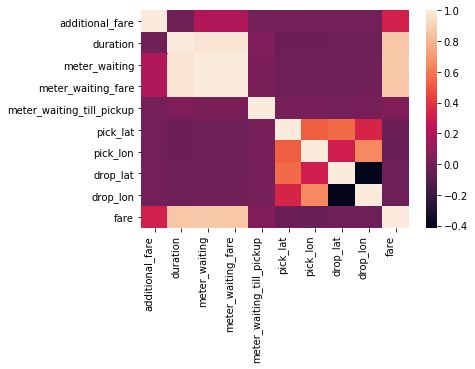

In [137]:
correlations = features_df.corr()

ax = sns.heatmap(
    correlations, 
    #vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    #square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

#features_df.drop(['meter_waiting', 'meter_waiting_fare'], axis=1)

In [122]:
est_mlp = MLPClassifier(hidden_layer_sizes=(200,), learning_rate='invscaling', learning_rate_init=0.01,
                          power_t=0.5, max_iter=500, shuffle=True, tol=0.0001, 
                          early_stopping=False, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000,
                         random_state=RANDOM_SEED)
est_xgb = XGBClassifier(max_depth=3, min_child_weight=1, gamma=0, reg_lambda=1, reg_alpha=1)
est_gb = GradientBoostingClassifier(random_state=8, n_estimators=200)
est_rn = RandomForestClassifier(max_depth=7)

estimators_stacked = [('xbg', est_xgb),
              ('mlp', est_mlp),
              ('gb', est_gb),
              ('rn', est_rn)
             ]

stacked_estimator =  StackingClassifier(estimators=estimators_stacked,
                                    final_estimator=LogisticRegression(),
                                    stack_method='predict_proba'
                                  )

In [162]:
seperate_processing_cols = []

numeric_cols = features_df.columns.values
numeric_cols = [x for x in numeric_cols if (x not in seperate_processing_cols)]
#numeric_cols = features_df.columns[features_df.dtypes != "object"].values
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)

preprocessor = Pipeline([
    ('Date_converter', transformer),
    ('distance', distanceTransformer),
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('standard_scaler', StandardScaler()),
    #('sample', SMOTE(random_state=RANDOM_SEED, sampling_strategy=0.3)),
    #('basis expansion', PolynomialFeatures(2))
    ("estimator", stacked_estimator)
])



In [163]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
])


#splitting the dataset
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

#Hub - Training
full_pipeline.fit(X_train, y_train.values.ravel())

#Hub - y values for the training x data


Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('Date_converter',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function convertTime at 0x000001C835497378>,
                                                      inv_kw_args=None,
                                                      inverse_func=None,
                                                      kw_args=None,
                                                      validate=False)),
                                 ('distance',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function crea...
                                           

In [164]:
y_pred_train= full_pipeline.predict(X_train)
y_pred= full_pipeline.predict(X_eval)

In [165]:
#Hub
f1_score(y_train, y_pred_train, average=None)

array([0.79308642, 0.98003716])

In [166]:
f1_score(y_eval, y_pred, average=None)

array([0.72893401, 0.97421037])

In [148]:
param_test1 = {

 'preprocessor__estimator__min_child_weight':range(1,6,2)
}

param_test2 = {
 'preprocessor__estimator__gamma':[i/10.0 for i in range(0,5)]
}

param_test3 = {
 'preprocessor__estimator__min_child_weight':range(1,6,2),
 'preprocessor__estimator__reg_alpha': range(1,60,10),
 'preprocessor__estimator__reg_lambda': range(1,60,10)
}

param_opt = GridSearchCV(estimator=full_pipeline, param_grid=param_test3, scoring='f1')


In [ ]:
%%time

# Train model
full_pipeline.fit(X_train, y_train.values.ravel())

# Predict on evaluation set
preds = full_pipeline.predict(X_eval)
preds

y_preds = pd.DataFrame(
    {
        "label": preds,
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

C:\Users\pgunarathna\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
f1_score(y_eval, y_preds, average=None)

In [ ]:
f1_score(y_eval, y_preds, average='macro')

In [167]:
%%time 

full_pipeline.fit(features_df, labels_df.values.ravel())

None   # So we don't print out the whole pipeline representation

Wall time: 1min 57s


In [ ]:


test_features_df['drop_time'] = test_features_df['drop_time'].astype('datetime64[m]')
test_features_df['pickup_time'] = test_features_df['pickup_time'].astype('datetime64[m]')

test_features_df['drop_time'] = [time.minute for time in test_features_df['drop_time']]
test_features_df['pickup_time'] = [time.minute for time in test_features_df['pickup_time']]


In [35]:
test_features_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [168]:
test_score1 = full_pipeline.predict(test_features_df)
test_score1

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [169]:
test_score1.shape

(8576,)

In [170]:
y_preds1 = pd.DataFrame(
    {
        # "label": test_score1[:,0],
        "label": test_score1,
    },
    index = test_features_df.index
)
print("y_preds1.shape:", y_preds1.shape)
y_preds1.head()

y_preds1.shape: (8576, 1)


,label
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [171]:
submission_df = pd.read_csv("sample_submission.csv", 
                            index_col="tripid")

In [172]:
submission_df.head()

,prediction
tripid,
213284604,1
213286352,0
213293973,0
213294622,1
213298687,1


In [173]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

In [174]:
# Save predictions to submission data frame
submission_df["prediction"] = test_score1

submission_df.head()

,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [175]:
submission_df.to_csv('my_submission10.csv', index=True)

In [42]:
!head my_submission8.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


In [0]:
# X_train.label
# dfs = np.split(X_train, [12], axis=1)
# X_train_features=dfs[0]
# y_train_labels=dfs[1]

In [0]:
# X_eval.label
# dfs = np.split(X_eval, [12], axis=1)
# X_eval_features=dfs[0]
# y_eval_labels=dfs[1]